In [1]:
import numpy as np
import scipy as scp
import pandas as pd

import h5py 
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing

from multiprocessing import Pool


### load  data

In [2]:
# load data

# open file
f = h5py.File("data_reextracted.hdf5", "r")

wave_normal = np.array(f['wave_control'])
wave_blocked = np.array(f['wave_blocked'])
wavelength = np.array(f['wavelength'])
opsins = np.array(f['opsins'])

for item in f.attrs:
    print(item, f.attrs[item])

f.close()

wave_blocked_raw = np.copy(wave_blocked)
wave_control_raw = np.copy(wave_normal)
opsins_raw = np.copy(opsins)

# normalizing
for i in range(4):
    wave_blocked[i] = wave_blocked[i] - np.min(wave_blocked[i])
    wave_blocked[i] = wave_blocked[i] / np.max(abs(wave_blocked[i]))
    
    wave_normal[i] = wave_normal[i] / np.max(abs(wave_normal[i]))
    
    opsins[i] =  opsins[i] - np.max(opsins[i])
    opsins[i] =  opsins[i] / np.min(opsins[i])

"""
load zone specific data
"""

filepath = 'data/all_cone_recordings/csvs/'
filenames = ['R-Cone recordings - control_merged.csv',
            'G-Cone recordings - control_merged.csv',
            'B-Cone recordings - control_merged.csv',
            'U-Cone recordings - control_merged.csv']

df_zones = pd.DataFrame()
for item in filenames:
    print(item)
    filename = filepath + item
    df1 = pd.read_csv(filename, sep=';',decimal=',')
    df_zones = df_zones.append(df1)


# convert to floats
for item in df_zones.columns[:13]:
    df_zones[item] = (df_zones[item].replace(',','.', regex=True).astype(float))
    

# load LED wavelenghts
filename = filepath + 'LED wavelength.csv'
led_wavelength =  pd.read_csv(filename, sep=';',decimal=',')
   
"""
preprocess data
"""
zones = ['SZ','Nasal','Dorsal','Ventral']

control_regionwise = np.zeros((4,4,296))
control_all_new = np.zeros((4,296))


for region_nr, region in enumerate(zones):
    for cone_nr, cone_type in enumerate(['R','G','B','U']):

        # get data
        data = df_zones[(df_zones.region==region)&(df_zones.cone_type==cone_type)].values[:,:13]
        data_all = df_zones[(df_zones.cone_type==cone_type)].values[:,:13]

        # interpolate
        data = scp.interpolate.interp1d(led_wavelength.Wavelength.values,data.mean(0))(wavelength)
        data_all = scp.interpolate.interp1d(led_wavelength.Wavelength.values,data_all.mean(0))(wavelength)

        # normalize
        data = -data / np.max(abs(data))
        data_all = -data_all / np.max(abs(data_all))
        
        # put to dataframe
        control_regionwise[region_nr, cone_nr] = data
        control_all_new[cone_nr] = data_all

"""
and cone specifig HC_block
"""

filepath = 'data/all_cone_recordings/csvs/'
filenames = ['R-Cone recordings - HCblock - regions_merged.csv',
            'G-Cone recordings - HCblock - regions_merged.csv',
            'B-Cone recordings - HCblock - regions_merged.csv',
            'U-Cone recordings - HCblock - regions_merged.csv']
             
df_zones_block = pd.DataFrame()
for item in filenames:
    print(item)
    filename = filepath + item
    df1 = pd.read_csv(filename, sep=';',decimal=',')
    df_zones_block = df_zones.append(df1)


# convert to floats
for item in df_zones.columns[:13]:
    df_zones_block[item] = (df_zones_block[item].replace(',','.', regex=True).astype(float))
    
    
"""
preprocess data
"""
zones = ['SZ','Nasal','Dorsal','Ventral']

block_regionwise = np.zeros((4,4,296))
block_all_new = np.zeros((4,296))


for region_nr, region in enumerate(zones):
    for cone_nr, cone_type in enumerate(['R','G','B','U']):

        # get data
        data = df_zones_block[(df_zones_block.region==region)&(df_zones_block.cone_type==cone_type)].values[:,:13]
        data_all = df_zones_block[(df_zones_block.cone_type==cone_type)].values[:,:13]

        # interpolate
        data = scp.interpolate.interp1d(led_wavelength.Wavelength.values,data.mean(0))(wavelength)
        data_all = scp.interpolate.interp1d(led_wavelength.Wavelength.values,data_all.mean(0))(wavelength)

        # normalize
        
        data = -data -np.min(-data)
        data /= np.max(abs(data))
        
        data_all = -data_all  -np.min(-data_all)

        data_all /= np.max(abs(data_all))
        
        # put to dataframe
        block_regionwise[region_nr, cone_nr] = data
        block_all_new[cone_nr] = data_all


info: cone signals under normal and rescaled conditions. In order R,G,B,UV, aligned to wavelength axis. Same for opsins.
R-Cone recordings - control_merged.csv
G-Cone recordings - control_merged.csv
B-Cone recordings - control_merged.csv
U-Cone recordings - control_merged.csv
R-Cone recordings - HCblock - regions_merged.csv
G-Cone recordings - HCblock - regions_merged.csv
B-Cone recordings - HCblock - regions_merged.csv
U-Cone recordings - HCblock - regions_merged.csv


Text(0.5, 0, 'wavelength')

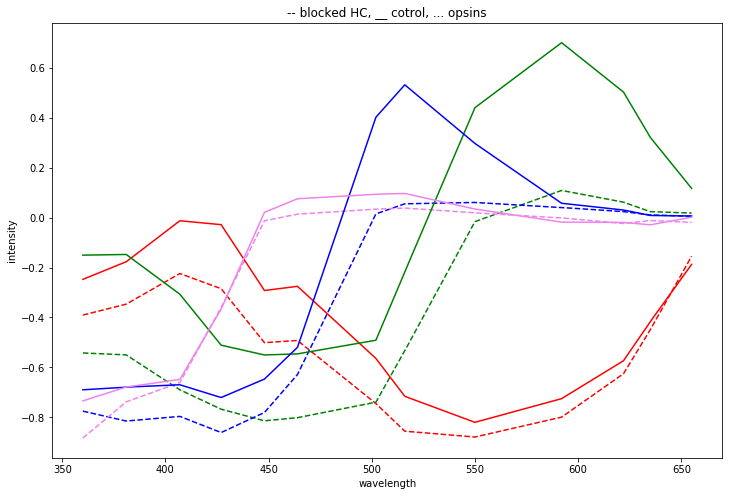

In [7]:
colors = ['r', 'g', 'b','violet' ]


plt.figure(figsize=(12,8))

plt.title('-- blocked HC, __ cotrol, ... opsins')
for i in range(4):
    plt.plot(wavelength, wave_blocked_raw[i], '--', color=colors[i], label='blocked')
    #plt.plot(wavelength, opsins[i], ':', color=colors[i], label='opsins')


for i in range(4):
    plt.plot(wavelength, wave_control_raw[i], color=colors[i], label='control condition')

plt.ylabel('intensity')
plt.xlabel('wavelength')
#plt.legend()

Text(0.5, 0, 'wavelength')

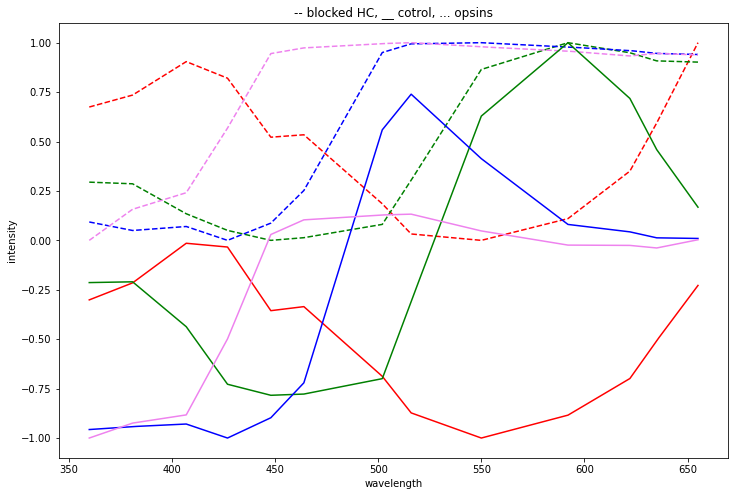

In [4]:
colors = ['r', 'g', 'b','violet' ]


plt.figure(figsize=(12,8))

plt.title('-- blocked HC, __ cotrol, ... opsins')
for i in range(4):
    plt.plot(wavelength, wave_blocked[i], '--', color=colors[i], label='blocked')
    #plt.plot(wavelength, opsins[i], ':', color=colors[i], label='opsins')


for i in range(4):
    plt.plot(wavelength, wave_normal[i], color=colors[i], label='control condition')

plt.ylabel('intensity')
plt.xlabel('wavelength')
#plt.legend()

Text(0.5, 0, 'wavelength')

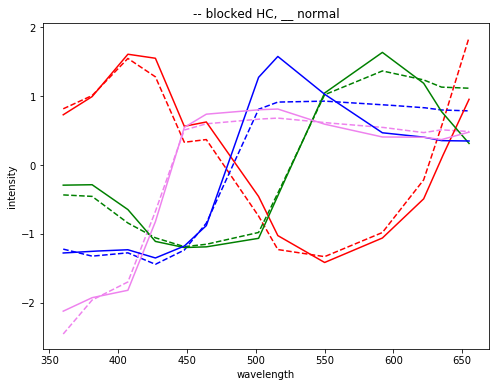

In [5]:
"""
"""

def z_score(data):
    x = data-np.mean(data)
    return x/np.std(data)


colors = ['r', 'g', 'b','violet' ]


plt.figure(figsize=(8,6))

plt.title('-- blocked HC, __ normal')
for i in range(4):
    plt.plot(wavelength, z_score(wave_blocked[i]), '--', color=colors[i], label='blocked')

for i in range(4):
    plt.plot(wavelength, z_score(wave_normal[i]), color=colors[i], label='normal condition')


plt.ylabel('intensity')
plt.xlabel('wavelength')
#plt.legend()

### define model

In [3]:
"""
data and functions 
"""

import sys 
sys.path.append('/gpfs01/berens/user/cschroeder/Documents/Biophysical Models/Cone_HC_interaction/Delfi')

from hc_model import run_model_hc, extract_params, get_param_labels
from parallel_running import run_model_x


# defining input
o = wave_blocked # seen as opsin tuning curves
k_data = wave_normal # recoreded data we want to fit




def get_loss(k_data,k_fit):
    """
    returns loss between k_data and k_fit
    SE atm
    """
    SE = 1/(np.shape(k_data)[0]*np.shape(k_data)[1]) * np.sum((k_data-k_fit)**2)
    return np.sqrt(SE)


In [4]:
"""
run model without HC
"""

# connectivity pattern
# initialize by c for found connections
const = 1
w = np.zeros((3,4))
#w[0,0]= const
#w[0,1] = const
#w[0,2] = const
#w[1,1] = const
#w[1,2] = const
#w[1,3] = const
#w[2,2] = const
#w[2,3] = const

# synaptic (output) strength per HC (HC_j -> cone) (constant over the different cone types)
a = np.zeros(3)

# dark current (can also be seen as synaptic strength cone_i -> HC )
# fixed here
dc = np.ones(4)
#dc[0] = dc0
#dc[1] = dc1
#dc[2] = 1
#dc[3] = 2
    
o = wave_blocked


k_no_HC = run_model_hc(o,w, dc,a, N=200)

loss_noHC = get_loss(k_data,k_no_HC)




In [8]:
loss_noHC

0.327282196924212

In [5]:
# on different zones
for i in range(4):
    print( get_loss(control_regionwise[i],k_no_HC) )
    
print('on zone ignorant data:', get_loss(k_data,k_no_HC) )

0.32052512664602556
0.3725892513883455
0.42321111101375336
0.41115000481829744
on zone ignorant data: 0.327282196924212


In [6]:
# with different zone specific input
k_no_HC_zonespecific = []
for i in range(4):
    k_no_HC_zonespecific.append(run_model_hc(block_regionwise[i],w, dc,a, N=200))
    print( get_loss(control_regionwise[i],k_no_HC_zonespecific[i]) )

0.37710296133960486
0.3743225781033606
0.45974096330327946
0.41206965253445815


Text(0.5, 0, 'wavelength')

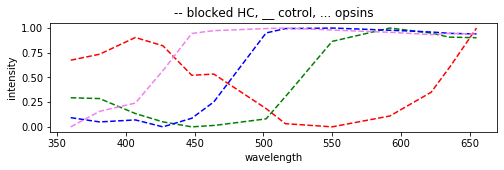

In [12]:
colors = ['r', 'g', 'b','violet' ]


plt.figure(figsize=(8,2))

plt.title('-- blocked HC, __ cotrol, ... opsins')
for i in range(4):
    plt.plot(wavelength, wave_blocked[i], '--', color=colors[i], label='blocked')
    #plt.plot(wavelength, opsins[i], ':', color=colors[i], label='opsins')


#for i in range(4):
#    plt.plot(wavelength, wave_normal[i], color=colors[i], label='control condition')

plt.ylabel('intensity')
plt.xlabel('wavelength')
#plt.legend()

## load SNPE models

In [7]:
modes =   [['HC0', 'HC1', 'HC2'],
     ['HC0', 'HC1'],
     ['HC0', 'HC2'],
     ['HC1', 'HC2'],
     ['HC0'],
     ['HC1'],
     ['HC2'],
    'special']

In [8]:
"""
load Delfi best params
"""

folderpath = '/gpfs01/berens/user/cschroeder/Documents/Biophysical Models/Cone_HC_interaction/Delfi/fit_results/regionwise'

filename = 'bestparams_regionwise.pkl'
#filename = 'bestparams_regionwise_zonespecific_input.pkl'


with open(folderpath+'/'+filename, "rb") as f:
    dictname = pickle.load(f)

    
   
"""
extract data from regionwise
"""

loss_delfi = np.zeros(4)
params_delfi = []
for i in range(4):
    loss_delfi[i] = dictname[i]['loss_0']
    params_delfi.append(dictname[i]['params_0'])
    
  
        
"""
runs sims
"""
k_delfi = []
k_delfi_test = []

loss_delfi_check = np.zeros(4)
for i in range(4):
    k_delfi_test.append(run_model_x(params_delfi[i], wave_blocked, mode=modes[0], N=200))
    k_delfi.append(run_model_x(params_delfi[i], block_regionwise[i], mode=modes[0], N=200))
    loss_delfi_check[i] = get_loss(k_delfi[i],control_regionwise[i])
    
    

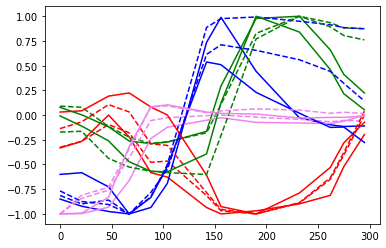

In [27]:
for region in range(2,4):
    for i in range(4):
        plt.plot(k_delfi[region][i],color=colors[i])

        plt.plot(k_delfi_test[region][i], color=colors[i], ls='--')

In [61]:
loss_delfi_check

array([0.16274904, 0.13543945, 0.24884653, 0.2321374 ])

In [60]:
loss_delfi

array([0.12569888, 0.11247975, 0.15184004, 0.12283986])

In [30]:
loss_noHC

0.327282196924212

In [31]:
"""
from original model
"""
folderpath = '/gpfs01/berens/user/cschroeder/Documents/Biophysical Models/Cone_HC_interaction/Delfi/fit_results/v2'



filename = 'bestparams.pkl'

with open(folderpath+'/'+filename, "rb") as f:
    dictname_orig = pickle.load(f)

i = 0
loss_orig = dictname_orig[i]['loss_0']
best_params_orig = dictname_orig[0]['params_0']



In [32]:
best_params_orig

array([ 0.77960207,  1.50815095,  0.58999491,  0.15657358,  2.29812179,
        1.24537931, -1.32842322,  3.02619474,  0.32443147,  2.31385086,
        1.38791226,  0.44364034])

In [33]:
loss_orig

0.09043270327216314

In [34]:
loss_delfi

array([0.0903429 , 0.06973169, 0.05360061, 0.0606258 ])

In [23]:
loss_delfi_check

array([0.12569888, 0.11247975, 0.15184004, 0.12283986])

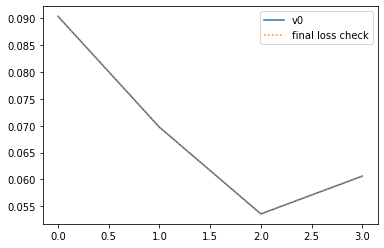

In [35]:
plt.plot(loss_delfi, label='v0')
plt.plot(loss_delfi_check, label='final loss check', ls=':')

plt.legend()

In [36]:
"""
set to best parameters
"""

# set to delfi
loss_best = np.copy(loss_delfi)
k_best = np.copy(k_delfi)
best_params = params_delfi




The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


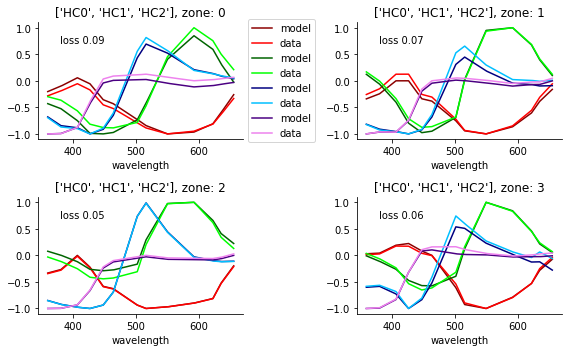

In [41]:
"""
plot best evaluations
"""
save = True


colors = ['r', 'lime', 'deepskyblue','violet' ]
colors2 = ['darkred','darkgreen','navy','indigo']

plt.figure(figsize=(8,5))
c=0
for j in range(4):
    
    plt.subplot(2,2,j+1+c)
    if j<7:
        mode = modes[0]
        plt.title(str(mode)+', zone: '+str(j))
        plt.text(380,0.7,'loss %.2f'%loss_best[j])
        for i in range(4):
            plt.plot(wavelength,k_best[j][i] ,'-', color=colors2[i], label='model', alpha=1)
            plt.plot(wavelength, control_regionwise[j][i],'-', color=colors[i], label='data')
    else:
        plt.title('no HC')
        plt.text(380,0.7,'loss %.2f'%loss_noHC)
        for i in range(4):
            plt.plot(wavelength, k_no_HC[i], '-',color=colors2[i], label='model', alpha=1)
            plt.plot(wavelength, wave_normal[i],'-', color=colors[i], label='data')
            #plt.plot(wavelength, o[i], color=colors[i], label='data, HC-blocked', alpha=0.5)
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


        
        
    
    if j==0:
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
    plt.xlabel('wavelength')


    plt.xlabel('wavelength')

plt.tight_layout()
sns.despine()

if save:
    filepath = '/gpfs01/berens/user/cschroeder/Documents/Biophysical Models/Cone_HC_interaction/Delfi/plots/pcs_regionwise_fits/'
    filename = 'best_models_regionwise_zonespecific_input'
    plt.savefig(filepath+filename+'.svg', dpi=300, format='svg',  bbox_inches='tight')
    plt.savefig(filepath+filename+'.eps', dpi=300, format='eps',  bbox_inches='tight')
    plt.savefig(filepath+filename+'.png', dpi=300, format='png',  bbox_inches='tight')

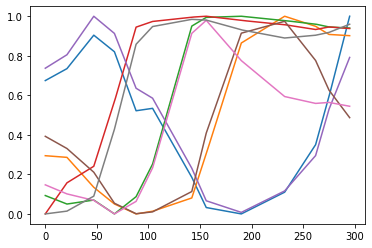

In [40]:
plt.plot(wave_blocked.T)
plt.plot(block_regionwise.mean(axis=0).T)

## plot losses

In [42]:
"""
load losses V2 
including of uncorrelated draws
"""

load_uncorrelated=False

# load losses of correct posteriors
filename = 'simulations_posteriors_regionwise_zonespecific_input_0.pkl'
folderpath = 'Delfi/fit_results/regionwise/'
with open(folderpath+'/'+filename, "rb") as f:
    dictname = pickle.load(f)


# load only losses 
loss_mean2 = dictname['loss_mean'] 
loss_std2 = dictname['loss_std'] 
accepted_sims2 = dictname['accepted_sims'] 
loss_percentiles_25_75 = dictname['loss_percentiles_25_75'] 


# load losses of correct posteriors
if load_uncorrelated:

    filename = 'simulations_posteriors_uncorrelated_0.pkl'
    folderpath = 'Delfi/fit_results/v2'
    with open(folderpath+'/'+filename, "rb") as f:
        dictname = pickle.load(f)

    loss_uncorrelated_mean = dictname['loss_uncorrelated_mean']
    loss_uncorrelated_std = dictname['loss_uncorrelated_std']
    accepted_sims_uncorrelated = dictname['accepted_sims_uncorrelated']
    loss_percentiles_uncorrelated_25_75 = dictname['loss_percentiles_uncorrelated_25_75']



In [43]:
"""
append loss of no HC
"""
loss_all = np.hstack( [loss_best, loss_noHC])

In [44]:
loss_percentiles_25_75

array([[0.20962349, 0.21976393, 0.23106574],
       [0.18895641, 0.2028249 , 0.21648875],
       [0.26167505, 0.28249922, 0.30947877],
       [0.23023765, 0.2439389 , 0.2611059 ]])

In [45]:
loss_noHC

0.327282196924212

In [46]:

"""
normalize losses
"""
# loss_all = best losses

def normalize_loss(loss_base, loss, return_factor=False, fix_max=True):
    """
    loss_base: the losses to normalize on
    loss: the vector which is normalized
    fix_max: normalizes max to the fixed last entry of loss_base (noHC model)
    """
    
    shift = np.min(loss_base)
    y_base = loss_base - shift
    
    if fix_max:
        div = y_base[-1]
    else:
        div = np.max(y_base)
        
    y_base = y_base /div
    
    y = loss-shift
    y = y/div
    if return_factor:
        return y, 1/div
    else:
        return y

# normalize best losses
# exclude special mode (as it is biological not plausible)
#loss_base = loss_all[np.arange(len(loss_all))!=7] 

loss_base = loss_all


"""
normalize mean losses

to best trace
"""

loss_norm = normalize_loss(loss_base, loss_all, return_factor=False)


loss_percentiles_norm = normalize_loss(loss_base, loss_percentiles_25_75)

#loss_percentiles_uncorrelated_norm = normalize_loss(loss_all, loss_percentiles_uncorrelated_25_75)



"""
normalize mean losses

to modes (APPEND lossnoHC before!!!)
"""
#loss_norm = normalize_loss(loss_percentiles2[:,1], loss_all, return_factor=False)

#loss_percentiles_norm = normalize_loss(loss_percentiles2[:,1], loss_percentiles2)

#loss_percentiles_uncorrelated_norm = normalize_loss(loss_percentiles2[:,1], loss_percentiles_uncorrelated)


'\nnormalize mean losses\n\nto modes (APPEND lossnoHC before!!!)\n'

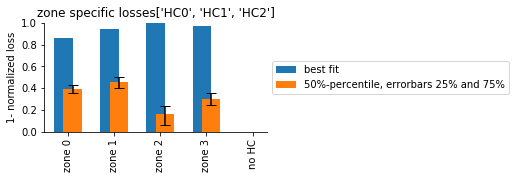

In [47]:
"""
normalized loss
"""
save = False

plot_best = True

plot_uncorrelated_loss = False

# compute errorbars
errorbars = np.abs(np.delete(loss_percentiles_norm, 1, axis=1).T 
                   - np.array([loss_percentiles_norm[:,1],
                               loss_percentiles_norm[:,1]]))[::-1]

if plot_uncorrelated_loss:
    # compute errorbars for uncorrrelated
    errorbars_uncorrelated = np.abs(np.delete(loss_percentiles_uncorrelated_norm, 1, axis=1).T 
                       - np.array([loss_percentiles_uncorrelated_norm[:,1],
                                   loss_percentiles_uncorrelated_norm[:,1]]))[::-1]


width = 0.4
if plot_uncorrelated_loss:
    shift = [-0.2,0,0.2]
else:
    shift = [-0.1,0.1]
    
#modes_all = [modes[0],modes[0],modes[0],modes[0], ['no HC'] ]
modes_all = ['zone 0','zone 1','zone 2','zone 3','no HC']

ticks = np.arange(0,5)


plt.figure(figsize=(4,2))
#plt.plot(loss_norm, 'o')
plt.title('zone specific losses'+str(modes[0]))


# best loss
if plot_best:
    plt.bar(ticks+shift[0],
            1-loss_norm, 
            width=width, 
           label='best fit')


# mean loss
plt.bar(ticks[:-1]+shift[1], 
        1-loss_percentiles_norm[:,1], 
        width=width,
       yerr=errorbars,
       capsize=5,
       label='50%-percentile, errorbars 25% and 75%')

# plot losses of uncorrelated samples
if plot_uncorrelated_loss:
    plt.bar(ticks[:-1]+shift[2], 
        1-loss_percentiles_uncorrelated_norm[:,1], 
        width=width,
       yerr=errorbars_uncorrelated,
       capsize=5,
       label='50%-percentile, errorbars 25% and 75%, diag-Cov')



plt.ylim(0,1)
#plt.ylabel('normalized loss')
plt.ylabel('1- normalized loss')

locs, labels = plt.xticks()            # Get locations and labels
plt.xticks(ticks, modes_all,rotation=90)  # Set locations and labels

sns.despine()
#plt.tight_layout()

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


if save:
    filepath = '/gpfs01/berens/user/cschroeder/Documents/Biophysical Models/Cone_HC_interaction/Delfi/plots/pcs_regionwise_fits/'
    filename = 'loss_percentiles_regionwise'
    plt.savefig(filepath+filename+'.svg', dpi=300, format='svg',  bbox_inches='tight')
    plt.savefig(filepath+filename+'.eps', dpi=300, format='eps',  bbox_inches='tight')
    plt.savefig(filepath+filename+'.png', dpi=300, format='png',  bbox_inches='tight')

In [69]:
"""
best losses for different regionwise models
"""
loss_regionwise_zonespecific = np.array([0.0903429 , 0.06973169, 0.05360061, 0.0606258 ])
loss_regionwise = np.array([0.12569888, 0.11247975, 0.15184004, 0.12283986])
loss_noHC = 0.327282196924212 # based on unspecific zone model
loss_orig = 0.09043270327216314 # unspecific best model


def normalize_loss(loss, loss_min, loss_max, ):
    """
    loss: the vector which is normalized
    """
    y = loss-loss_min
    y /= (loss_max-loss_min)

    return y


# normalize 
loss_regionwise_zonespecific_norm = normalize_loss(loss_regionwise_zonespecific,loss_orig, loss_noHC )
loss_regionwise_norm = normalize_loss(loss_regionwise,loss_orig, loss_noHC )
loss_noHC_norm = normalize_loss(loss_noHC,loss_orig, loss_noHC )
loss_orig_norm = normalize_loss(loss_orig,loss_orig, loss_noHC )

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


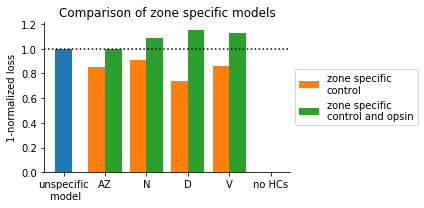

In [110]:
"""
plot zonespecific loss comparison
"""
save = True

x_labels = ['unspecific\n model', 'AZ', 'N', 'D','V', 'no HCs']

# set width of bars
width = 0.4

plt.figure(1,figsize=(6,3))
plt.title('Comparison of zone specific models')

# unspecific
plt.bar(0,1-loss_orig_norm, width=width)

plt.bar(np.arange(1,5)-0.2,1-loss_regionwise_norm, width=width, label='zone specific \ncontrol')
plt.bar(np.arange(1,5)+0.2,1-loss_regionwise_zonespecific_norm, width=width,label='zone specific \ncontrol and opsin')

# no HC
plt.bar(5,1-loss_noHC_norm,width=width)

plt.xticks(np.arange(6))
ax=plt.gca()
ax.set_xticklabels(x_labels)
plt.axhline(1, color='black', ls=':')

plt.ylabel('1-normalized loss')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
sns.despine()
plt.tight_layout()


if save:
    filepath = '/gpfs01/berens/user/cschroeder/Documents/Biophysical Models/Cone_HC_interaction/Delfi/plots/pcs_regionwise_fits/'
    filename = 'zonespecific_loss_comparison'
    plt.savefig(filepath+filename+'.svg', dpi=300, format='svg',  bbox_inches='tight')
    plt.savefig(filepath+filename+'.eps', dpi=300, format='eps',  bbox_inches='tight')
    plt.savefig(filepath+filename+'.png', dpi=300, format='png',  bbox_inches='tight')

In [100]:
loss_regionwise_zonespecific_norm

array([-0.00037916, -0.08740155, -0.15550843, -0.12584744])

In [69]:
1-loss_norm

array([0.93845915, 1.        , 0.81676055, 0.95176916, 0.        ])

### plot connectivity strengths

In [48]:
"""
load sampled params
"""

# load losses of correct posteriors
filename = 'simulations_posteriors_regionwise_zonespecific_input_0.pkl'
folderpath = 'Delfi/fit_results/regionwise'
with open(folderpath+'/'+filename, "rb") as f:
    dictname = pickle.load(f)



    
    
    

In [49]:
"""
load original model samples
"""

# load losses of correct posteriors
filename = 'simulations_posteriors_0.pkl'
folderpath = 'Delfi/fit_results/v2'
with open(folderpath+'/'+filename, "rb") as f:
    dictname_original = pickle.load(f)

In [71]:
modes

[['HC0', 'HC1', 'HC2'],
 ['HC0', 'HC1'],
 ['HC0', 'HC2'],
 ['HC1', 'HC2'],
 ['HC0'],
 ['HC1'],
 ['HC2'],
 'special']

In [51]:
dictname_original[0].keys()

dict_keys(['mode', 'a', 'mus', 'covs', 'mu_proj', 'cov_proj', 'samples', 'evaluations', 'loss', 'H_in'])

In [52]:
"""
extract samples
"""
samples = []
for i in range(4):
    samples.append(np.array(dictname[i]['samples']))
    
samples.append(np.array(dictname_original[0]['samples']))

In [131]:
mean_params = []
std_params = []
percentile_params = [[] for _ in range(5)]
for i in range(4):
    mean_params.append(np.mean(np.array(dictname[i]['samples']), axis=0))
    std_params.append(np.std(np.array(dictname[i]['samples']), axis=0))
    percentile_params[i].append(np.percentile(np.array(dictname[i]['samples']),25, axis=0))
    percentile_params[i].append(np.percentile(np.array(dictname[i]['samples']),50, axis=0))
    percentile_params[i].append(np.percentile(np.array(dictname[i]['samples']),75, axis=0))
    
# original samples
i=0
mean_params.append(np.mean(np.array(dictname_original[i]['samples']), axis=0))
std_params.append(np.std(np.array(dictname_original[i]['samples']), axis=0))
percentile_params[i].append(np.percentile(np.array(dictname_original[i]['samples']),25, axis=0))
percentile_params[i].append(np.percentile(np.array(dictname_original[i]['samples']),50, axis=0))
percentile_params[i].append(np.percentile(np.array(dictname_original[i]['samples']),75, axis=0))

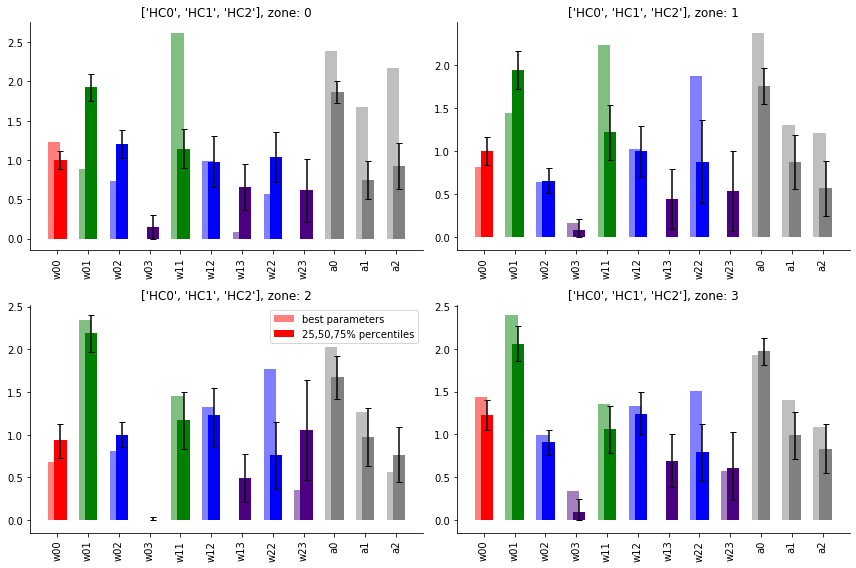

In [109]:
"""
plot fitted values 
BARPLOT PERCENTILES
"""

save = False
plot_mean = True

color = None
width = 0.4

# clip at 0 (this is done in model evaluation )
best_params_clipped = np.copy(best_params)
percentile_params_clipped = np.copy(percentile_params)

for i in range(len(best_params_clipped)):
    best_params_clipped[i][best_params_clipped[i]<0] = 0
    for j in range(3):
        percentile_params_clipped[i][j][percentile_params_clipped[i][j]<0] = 0

# compute errorbars
#errorbars = np.abs(np.delete(percentile_params_clipped, 1, axis=1).T 
#                   - np.array([percentile_params_clipped[:,1],
#                               percentile_params_clipped[:,1]]))
# compute errorbars
errorbars = np.abs(np.delete(percentile_params_clipped, 1, axis=1)
                   - np.hstack([percentile_params_clipped[:,1][:,np.newaxis,:],
           percentile_params_clipped[:,1][:,np.newaxis,:]]))

# specify modes
modes = [['HC0', 'HC1', 'HC2'],
 ['HC0', 'HC1'],
 ['HC0', 'HC2'],
 ['HC1', 'HC2'],
 ['HC0'],
 ['HC1'],
 ['HC2'],
 'special']
  
plt.figure(1, figsize=(12,8))
    
nround = 0

c=0
for i in range(4):
    mode = modes[0]

   
    # all HC
    x_label = get_param_labels(mode)
    color = ['r','g','b','indigo',
            'g','b', 'indigo',
            'b', 'indigo',
            'grey','grey','grey']
    #['r','g','b', 'indigo']
        
    ax = plt.subplot(2,2,i+1)
    plt.title(str(modes[0])+', zone: '+str(i))
    
    # best parameters
    plt.bar(np.arange(0,len(x_label))-0.1,
            best_params_clipped[i],
           color=color,
           width=width,
           alpha=0.5,
           label='best parameters')
    
    # mean parameters
    if plot_mean:
        plt.bar(np.arange(0,len(x_label))+0.1,
            percentile_params_clipped[i][1],
           color=color,
           width=width,
               alpha=1,
               yerr=[errorbars[i][0],errorbars[i][1]],
               capsize = 3,
               label='25,50,75% percentiles')
    
    plt.xticks(np.arange(0,len(x_label)))
    ax.set_xticklabels(x_label)
    plt.xticks(rotation=90)
    plt.ylim(-0.15)
    #plt.legend()
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # plot legend
    if i==2:
        plt.legend()    
plt.tight_layout()
sns.despine()



if save:
    filepath = '/gpfs01/berens/user/cschroeder/Documents/Biophysical Models/Cone_HC_interaction/Delfi/plots/pcs_regionwise_fits/'
    filename = 'weights_best_percentiles_25_75_regionwise'
    plt.savefig(filepath+filename+'.svg', dpi=300, format='svg',  bbox_inches='tight')
    plt.savefig(filepath+filename+'.eps', dpi=300, format='eps',  bbox_inches='tight')
    plt.savefig(filepath+filename+'.png', dpi=300, format='png',  bbox_inches='tight')

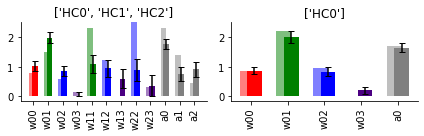

In [216]:
"""
plot fitted values 
BARPLOT PERCENTILES
SELECTED only
"""



save = False
plot_mean = True

color = None
width = 0.4

# clip at 0 (this is done in model evaluation )
best_params_clipped = np.copy(best_params)
percentile_params_clipped = np.copy(percentile_params)

for i in range(len(best_params_clipped)):
    best_params_clipped[i][best_params_clipped[i]<0] = 0
    for j in range(3):
        percentile_params_clipped[i][j][percentile_params_clipped[i][j]<0] = 0

# compute errorbars
errorbars = np.abs(np.delete(percentile_params_clipped, 1, axis=1).T 
                   - np.array([percentile_params_clipped[:,1],
                               percentile_params_clipped[:,1]]))

  
plt.figure(1, figsize=(6,2))
    
nround = 0

c=0
for i in [0,4]:
    mode = modes[i]

    if i==0:
        # all HC
        x_label = get_param_labels(mode)
        color = ['r','g','b','indigo',
                'g','b', 'indigo',
                'b', 'indigo',
                'grey','grey','grey']
        #['r','g','b', 'indigo']

    elif i==1:
        # HC0 and HC1
        x_label = get_param_labels(mode)
        color = ['r','g','b','indigo',
                'g','b', 'indigo',
                'grey','grey']

    elif i==2:
        # HC0 and HC2
        x_label =  get_param_labels(mode)
        color = ['r','g','b','indigo',
                'b', 'indigo',
                'grey','grey']

    elif i==3:
        # HC1 and HC2
        x_label =  get_param_labels(mode)
        color = ['g','b', 'indigo',
                'b', 'indigo',
                'grey','grey']

    elif i==4:
        # HC0
        x_label =  get_param_labels(mode)
        color = ['r','g','b','indigo',
                'grey']

    elif i==5:
        # HC1 
        x_label =  get_param_labels(mode)
        color = ['g','b', 'indigo',
                 'grey']

    elif i==6:
        # HC2
        x_label =  get_param_labels(mode)
        color=['b','indigo','grey']
        
    elif i==7:
        x_label =  get_param_labels(mode)
        color = ['r','g','b','indigo',
                 'r','g','b', 'indigo',
                 'b','indigo',
                 'grey','grey', 'grey']

    if i==1:
        c=2
        
    ax = plt.subplot(1,2,c+1)
    c+=1
    plt.title(modes[i])
    
    # best parameters
    plt.bar(np.arange(0,len(x_label))-0.1,
            best_params_clipped[i],
           color=color,
           width=width,
           alpha=0.5,
           label='best parameters')
    
    # mean parameters
    if plot_mean:
        plt.bar(np.arange(0,len(x_label))+0.1,
            percentile_params_clipped[i][1],
           color=color,
           width=width,
               alpha=1,
               yerr=[errorbars[0][i],errorbars[1][i]],
               capsize = 3,
               label='25,50,75% percentiles')
    
    plt.xticks(np.arange(0,len(x_label)))
    ax.set_xticklabels(x_label)
    plt.xticks(rotation=90)
    plt.ylim(-0.15,2.5)
    #plt.legend()
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#plt.legend()    
plt.tight_layout()
sns.despine()



if save:
    filepath = '/gpfs01/berens/user/cschroeder/Documents/Biophysical Models/Cone_HC_interaction/Delfi/plots/plots_v5/'
    filename = 'weights_best_only'
    plt.savefig(filepath+filename+'.svg', dpi=300, format='svg',  bbox_inches='tight')
    plt.savefig(filepath+filename+'.eps', dpi=300, format='eps',  bbox_inches='tight')
    plt.savefig(filepath+filename+'.png', dpi=300, format='png',  bbox_inches='tight')

### as boxplot 
_see: best_model_comparison.ipynb for old code._

# compute relative input to HC

In [53]:
def normalize_h_input_weight(params, mode):
    """
    normalizes w's to sum up to 1 per HC
    and also a's to sum up to 1
    """
    params = np.copy(params)
    params[params<0]=0
    params_norm = np.zeros(params.shape)
    
    if mode==0: # all
        params_norm[:4] = params[:4]/np.sum(params[:4])
        params_norm[4:7] = params[4:7]/np.sum(params[4:7])
        params_norm[7:9] = params[7:9]/np.sum(params[7:9])
        params_norm[9:] = params[9:]/np.sum(params[9:])
        
    elif mode==1: # H0,H1
        params_norm[:4] = params[:4]/np.sum(params[:4])
        params_norm[4:7] = params[4:7]/np.sum(params[4:7])
        params_norm[7:] = params[7:]/np.sum(params[7:])

    elif mode==2: # H0, H2
        params_norm[:4] = params[:4]/np.sum(params[:4])
        params_norm[4:6] = params[4:6]/np.sum(params[4:6])
        params_norm[6:] = params[6:]/np.sum(params[6:])
        
    elif mode==3: #H1, H2
        params_norm[:3] = params[:3]/np.sum(params[:3])
        params_norm[3:5] = params[3:5]/np.sum(params[3:5])
        params_norm[5:] = params[5:]/np.sum(params[5:])
        
    elif mode==4: #H0
        params_norm[:4] = params[:4]/np.sum(params[:4])
        params_norm[4:] = params[4:]/np.sum(params[4:])

    elif mode==5: #H1
        params_norm[:3] = params[:3]/np.sum(params[:3])
        params_norm[3:] = params[3:]/np.sum(params[3:])

    elif mode==6: #H2
        params_norm[:2] = params[:2]/np.sum(params[:2])
        params_norm[2:] = params[2:]/np.sum(params[2:])
        
    elif mode==7: # special
        params_norm[:4] = params[:4]/np.sum(params[:4])
        params_norm[4:8] = params[4:8]/np.sum(params[4:8])
        params_norm[8:10] = params[8:10]/np.sum(params[8:10])
        params_norm[10:] = params[10:]/np.sum(params[10:])
        
    params_norm[np.isnan(params_norm)]=0
    return params_norm

"""
normalize all samples
"""
samples_norm = [[] for _ in range(5)]
mode = 0
for i in range(4):
    for sample in dictname[i]['samples']:
        samples_norm[i].append(normalize_h_input_weight(sample, mode))

for sample in dictname_original[0]['samples']:
    samples_norm[4].append(normalize_h_input_weight(sample, mode))

"""
normalize best params
"""
best_params_norm = [[] for _ in range(5)]
for mode in range(4):
    best_params_norm[mode].append(normalize_h_input_weight(best_params[mode], mode=0))
    
best_params_norm[4].append(normalize_h_input_weight(np.clip(best_params_orig,0,100), mode=0))
 

<ipython-input-53-4c2c9f92386d>:13: RuntimeWarning: invalid value encountered in true_divide
  params_norm[7:9] = params[7:9]/np.sum(params[7:9])
<ipython-input-53-4c2c9f92386d>:12: RuntimeWarning: invalid value encountered in true_divide
  params_norm[4:7] = params[4:7]/np.sum(params[4:7])
<ipython-input-53-4c2c9f92386d>:11: RuntimeWarning: invalid value encountered in true_divide
  params_norm[:4] = params[:4]/np.sum(params[:4])


In [54]:
best_params_norm

[[array([0.06688712, 0.59891635, 0.33419654, 0.        , 0.33473253,
         0.25298751, 0.41227995, 1.        , 0.        , 0.4729417 ,
         0.16534072, 0.36171758])],
 [array([0.        , 0.47767814, 0.52232186, 0.        , 0.97395623,
         0.        , 0.02604377, 0.42147631, 0.57852369, 0.80413369,
         0.19586631, 0.        ])],
 [array([0.        , 0.41306623, 0.58693377, 0.        , 0.66511657,
         0.33488343, 0.        , 0.41360275, 0.58639725, 0.28365952,
         0.71634048, 0.        ])],
 [array([0.13055128, 0.37576181, 0.39128905, 0.10239786, 0.98674565,
         0.        , 0.01325435, 0.04962147, 0.95037853, 0.4340412 ,
         0.36177598, 0.20418282])],
 [array([0.25692797, 0.4970307 , 0.19444047, 0.05160085, 0.64854553,
         0.35145447, 0.        , 0.90317288, 0.09682712, 0.55817266,
         0.33480752, 0.10701982])]]

In [55]:
"""
compute percentiles of normalized params
"""
mean_params_norm = []
std_params_norm = []
percentile_params_norm = [[] for _ in range(5)]
for i in range(5):
    mean_params_norm.append(np.mean(samples_norm[i], axis=0))
    std_params_norm.append(np.std(samples_norm[i], axis=0))
    percentile_params_norm[i].append(np.percentile(samples_norm[i], 25, axis=0))
    percentile_params_norm[i].append(np.percentile(samples_norm[i], 50, axis=0))
    percentile_params_norm[i].append(np.percentile(samples_norm[i], 75, axis=0))
percentile_params_norm = np.array(percentile_params_norm) 
    

In [56]:
best_params_norm

[[array([0.06688712, 0.59891635, 0.33419654, 0.        , 0.33473253,
         0.25298751, 0.41227995, 1.        , 0.        , 0.4729417 ,
         0.16534072, 0.36171758])],
 [array([0.        , 0.47767814, 0.52232186, 0.        , 0.97395623,
         0.        , 0.02604377, 0.42147631, 0.57852369, 0.80413369,
         0.19586631, 0.        ])],
 [array([0.        , 0.41306623, 0.58693377, 0.        , 0.66511657,
         0.33488343, 0.        , 0.41360275, 0.58639725, 0.28365952,
         0.71634048, 0.        ])],
 [array([0.13055128, 0.37576181, 0.39128905, 0.10239786, 0.98674565,
         0.        , 0.01325435, 0.04962147, 0.95037853, 0.4340412 ,
         0.36177598, 0.20418282])],
 [array([0.25692797, 0.4970307 , 0.19444047, 0.05160085, 0.64854553,
         0.35145447, 0.        , 0.90317288, 0.09682712, 0.55817266,
         0.33480752, 0.10701982])]]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

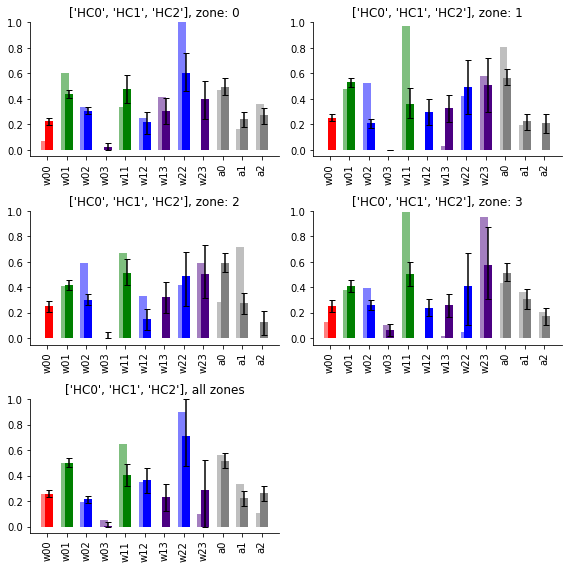

In [58]:
"""
plot NORMALIZED fitted values 
BARPLOT PERCENTILES
"""

save = True
plot_mean = True

color = None
width = 0.4



# compute errorbars
errorbars = np.abs(np.delete(percentile_params_norm, 1, axis=1)
                   - np.hstack([percentile_params_norm[:,1][:,np.newaxis,:],
           percentile_params_norm[:,1][:,np.newaxis,:]]))


# specify modes
modes = [['HC0', 'HC1', 'HC2'],
 ['HC0', 'HC1'],
 ['HC0', 'HC2'],
 ['HC1', 'HC2'],
 ['HC0'],
 ['HC1'],
 ['HC2'],
 'special']
  
plt.figure(1, figsize=(8,8))
    
nround = 0

c=0
for i in range(5):
    mode = modes[0]

    # all HC
    x_label = get_param_labels(mode)
    color = ['r','g','b','indigo',
            'g','b', 'indigo',
            'b', 'indigo',
            'grey','grey','grey']
    #['r','g','b', 'indigo']

   
        
    ax = plt.subplot(3,2,i+1)
    if i<4:
        plt.title(str(modes[0])+', zone: '+str(i))
    else:
        plt.title(str(modes[0])+', all zones')
    
    # best parameters
    plt.bar(np.arange(0,len(x_label))-0.1,
            best_params_norm[i][0],
           color=color,
           width=width,
           alpha=0.5,
           label='best parameters')
    
    # mean parameters
    if plot_mean:
        plt.bar(np.arange(0,len(x_label))+0.1,
            percentile_params_norm[i][1],
           color=color,
           width=width,
               alpha=1,
               yerr=[errorbars[i][0],errorbars[i][1]],
               capsize = 3,
               label='25,50,75% percentiles')
    
    plt.xticks(np.arange(0,len(x_label)))
    ax.set_xticklabels(x_label)
    plt.xticks(rotation=90)
    plt.ylim(-0.05,1)
    #plt.legend()
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # plot legend
    if i==10:
        plt.legend()    
plt.tight_layout()
sns.despine()



if save:
    filepath = '/gpfs01/berens/user/cschroeder/Documents/Biophysical Models/Cone_HC_interaction/Delfi/plots/pcs_regionwise_fits/'
    filename = 'weights_best_percentiles_25_75_normalized_regionwise_zonespecific_input'
    plt.savefig(filepath+filename+'.svg', dpi=300, format='svg',  bbox_inches='tight')
    plt.savefig(filepath+filename+'.eps', dpi=300, format='eps',  bbox_inches='tight')
    plt.savefig(filepath+filename+'.png', dpi=300, format='png',  bbox_inches='tight')

### Save best model to .csv file

In [182]:
best_params_norm = np.array(best_params_norm)
#best_params_norm = best_params_norm[:,0,:]

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [200]:
# convert to dataframe
df = pd.DataFrame(data=best_params_norm, columns=get_param_labels(modes[0]))

# round to percentages
df = df*100
df = df.round(decimals=1)

# add zones
df['zones'] =  ['AZ','Nasal','Dorsal','Ventral','all']

In [201]:
df

,w00,w01,w02,w03,w11,w12,w13,w22,w23,a0,a1,a2,zones
0,43.3,31.2,25.5,0.0,71.1,26.7,2.2,100.0,0.0,38.4,26.8,34.8,AZ
1,26.5,47.2,21.0,5.3,68.6,31.4,0.0,100.0,0.0,48.6,26.8,24.7,Nasal
2,17.8,61.1,21.1,0.0,52.3,47.7,0.0,83.3,16.7,52.5,32.8,14.7,Dorsal
3,27.9,46.2,19.3,6.6,50.4,49.6,0.0,72.6,27.4,43.6,31.7,24.7,Ventral
4,25.7,49.7,19.4,5.2,64.9,35.1,0.0,90.3,9.7,55.8,33.5,10.7,all


In [202]:
# save to csv
df.to_csv('best_models_zonespecific_weights_percentages.csv')

In [203]:
df.to_latex()

'\\begin{tabular}{lrrrrrrrrrrrrl}\n\\toprule\n{} &   w00 &   w01 &   w02 &  w03 &   w11 &   w12 &  w13 &    w22 &   w23 &    a0 &    a1 &    a2 &    zones \\\\\n\\midrule\n0 &  43.3 &  31.2 &  25.5 &  0.0 &  71.1 &  26.7 &  2.2 &  100.0 &   0.0 &  38.4 &  26.8 &  34.8 &       AZ \\\\\n1 &  26.5 &  47.2 &  21.0 &  5.3 &  68.6 &  31.4 &  0.0 &  100.0 &   0.0 &  48.6 &  26.8 &  24.7 &    Nasal \\\\\n2 &  17.8 &  61.1 &  21.1 &  0.0 &  52.3 &  47.7 &  0.0 &   83.3 &  16.7 &  52.5 &  32.8 &  14.7 &   Dorsal \\\\\n3 &  27.9 &  46.2 &  19.3 &  6.6 &  50.4 &  49.6 &  0.0 &   72.6 &  27.4 &  43.6 &  31.7 &  24.7 &  Ventral \\\\\n4 &  25.7 &  49.7 &  19.4 &  5.2 &  64.9 &  35.1 &  0.0 &   90.3 &   9.7 &  55.8 &  33.5 &  10.7 &      all \\\\\n\\bottomrule\n\\end{tabular}\n'

# Tuning curves

In [75]:
"""
load traces
"""

# load losses of correct posteriors
filename = 'simulations_posteriors_0.pkl'
folderpath = 'Delfi/fit_results/v2'
with open(folderpath+'/'+filename, "rb") as f:
    dictname = pickle.load(f)



In [78]:
"""
get percentiles for all traces
"""
traces_percentiles_25_75 = np.zeros((8,3,4,296))
#traces_percentiles_5_95 = np.zeros((8,3,4,296))
#traces_percentiles_34_66 = np.zeros((8,3,4,296))


for i in range(8):
    traces_percentiles_25_75[i,0] = np.percentile(np.array(dictname[i]['evaluations']),25, axis=0)
    traces_percentiles_25_75[i,1] = np.percentile(np.array(dictname[i]['evaluations']),50, axis=0)
    traces_percentiles_25_75[i,2] = np.percentile(np.array(dictname[i]['evaluations']),75, axis=0)
    
    #traces_percentiles_5_95[i,0] = np.percentile(np.array(dictname[i]['evaluations']),5, axis=0)
    #traces_percentiles_5_95[i,1] = np.percentile(np.array(dictname[i]['evaluations']),50, axis=0)
    #traces_percentiles_5_95[i,2] = np.percentile(np.array(dictname[i]['evaluations']),95, axis=0)
    
    #traces_percentiles_34_66[i,0] = np.percentile(np.array(dictname[i]['evaluations']),34, axis=0)
    #traces_percentiles_34_66[i,1] = np.percentile(np.array(dictname[i]['evaluations']),50, axis=0)
    #traces_percentiles_34_66[i,2] = np.percentile(np.array(dictname[i]['evaluations']),66, axis=0)
    print('finished mode',i)

finished mode 0
finished mode 1
finished mode 2
finished mode 3
finished mode 4
finished mode 5
finished mode 6
finished mode 7


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

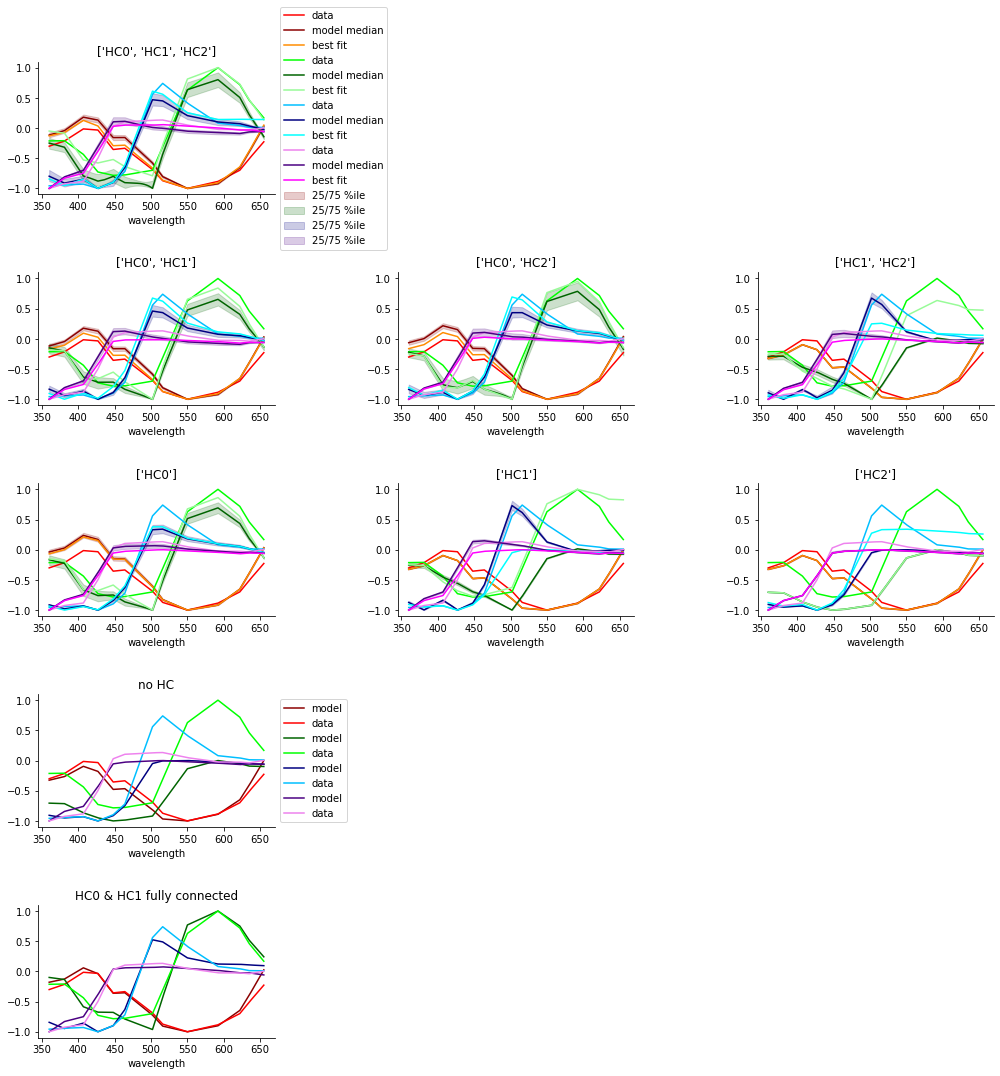

In [87]:

"""
plot 
"""
save = True

special_mode =True

plot_best = True

traces_percentiles = np.copy(traces_percentiles_25_75)

colors = ['r', 'lime', 'deepskyblue','violet' ]
colors2 = ['darkred','darkgreen','navy','indigo']
colors_best = ['darkorange', 'palegreen', 'cyan', 'magenta']

plt.figure(figsize=(14,15))
c=0
for j in range(8):
    
    if j==1:
        c=2
    
    plt.subplot(5,3,j+1+c)
    if j<7:
        mode = modes[j]
        plt.title(mode)
        #plt.text(380,0.7,'loss %.2f'%loss_best[j])
        for i in range(4):
            # data
            plt.plot(wavelength, 
                     wave_normal[i],
                     '-', 
                     color=colors[i], 
                     label='data')
            
            # fit median
            plt.plot(wavelength, 
                     traces_percentiles[j,1,i], '-', 
                     color=colors2[i], 
                     label='model median')    
            plt.fill_between(wavelength, 
                             traces_percentiles[j,0,i], 
                             traces_percentiles[j,2,i],
                             color=colors2[i], 
                             alpha=0.2, 
                             label='25/75 %ile')
            # fit best
            if plot_best:
                plt.plot(wavelength,k_best[j][i] ,
                         '-', 
                         color=colors_best[i], 
                         label='best fit')
                
                
        plt.ylim(-1.1,1.1)
        
    else:
        plt.title('no HC')
        #plt.text(380,0.7,'loss %.2f'%loss_noHC)
        for i in range(4):
            plt.plot(wavelength, k_no_HC[i], '-',color=colors2[i], label='model', alpha=1)
            plt.plot(wavelength, wave_normal[i],'-', color=colors[i], label='data')
            #plt.plot(wavelength, o[i], color=colors[i], label='data, HC-blocked', alpha=0.5)
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


        
        
    
    if j==0:
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
    plt.xlabel('wavelength')

if special_mode:
    # plot for special mode
    plt.subplot(5,3,13)
    plt.title('HC0 & HC1 fully connected')
    #plt.text(380,0.7,'loss %.2f'%loss_best[7])
    for i in range(4):
            pass
            plt.plot(wavelength,k_best[7][i] ,'-', color=colors2[i], label='model', alpha=1)
            plt.plot(wavelength, wave_normal[i],'-', color=colors[i], label='data')

    plt.xlabel('wavelength')

plt.tight_layout()
sns.despine()

if save:
    filepath = '/gpfs01/berens/user/cschroeder/Documents/Biophysical Models/Cone_HC_interaction/Delfi/plots/plots_v5/'
    filename = 'model_predictions'
    plt.savefig(filepath+filename+'.svg', dpi=300, format='svg',  bbox_inches='tight')
    plt.savefig(filepath+filename+'.eps', dpi=300, format='eps',  bbox_inches='tight')
    plt.savefig(filepath+filename+'.png', dpi=300, format='png',  bbox_inches='tight')

### compute HC spectra of best sims

In [82]:
modes = [['HC0', 'HC1', 'HC2'],
 ['HC0', 'HC1'],
 ['HC0', 'HC2'],
 ['HC1', 'HC2'],
 ['HC0'],
 ['HC1'],
 ['HC2'],
 'special'       ]#'special_H0_full']

In [83]:
"""
check output spectra
"""
H_spectra_all = []

for i, mode in enumerate(modes):
    print(i)

    w,dc,a = extract_params(best_params[i], mode=modes[i] )
    N = 200
    k_fit, H_in = run_model_hc(wave_blocked, w, dc, a, return_H_in=True)
    #k, k_store, H_in = get_output_spectra(wave_blocked,w,np.ones(4), a,N=N, return_H_in=True)
    H_spectra_all.append(H_in)

H_spectra_all = np.array(H_spectra_all)

0
1
2
3
4
5
6
7


In [84]:
H_spectra_all.shape

(8, 3, 296)

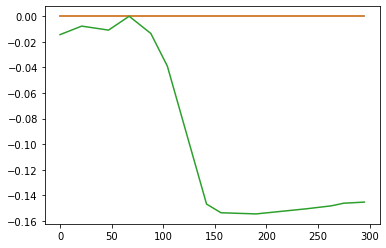

In [85]:
for i in range(3):
    plt.plot(H_spectra_all[6][i])

In [88]:
"""
load traces H_in
"""

# load losses of correct posteriors
filename = 'simulations_posteriors_0.pkl'
folderpath = 'Delfi/fit_results/v2'
with open(folderpath+'/'+filename, "rb") as f:
    dictname = pickle.load(f)



In [89]:
"""
get percentiles for all traces
"""
H_in_percentiles_25_75 = np.zeros((8,3,3,296))
H_in_percentiles_5_95 = np.zeros((8,3,3,296))

for i in range(8):
    H_in_percentiles_25_75[i,0] = np.percentile(np.array(dictname[i]['H_in']),25, axis=0)
    H_in_percentiles_25_75[i,1] = np.percentile(np.array(dictname[i]['H_in']),50, axis=0)
    H_in_percentiles_25_75[i,2] = np.percentile(np.array(dictname[i]['H_in']),75, axis=0)
    
    #H_in_percentiles_5_95[i,0] = np.percentile(np.array(dictname[i]['H_in']),5, axis=0)
    #H_in_percentiles_5_95[i,1] = np.percentile(np.array(dictname[i]['H_in']),50, axis=0)
    #H_in_percentiles_5_95[i,2] = np.percentile(np.array(dictname[i]['H_in']),95, axis=0)
    print('finished mode',i)

finished mode 0
finished mode 1
finished mode 2
finished mode 3
finished mode 4
finished mode 5
finished mode 6
finished mode 7


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

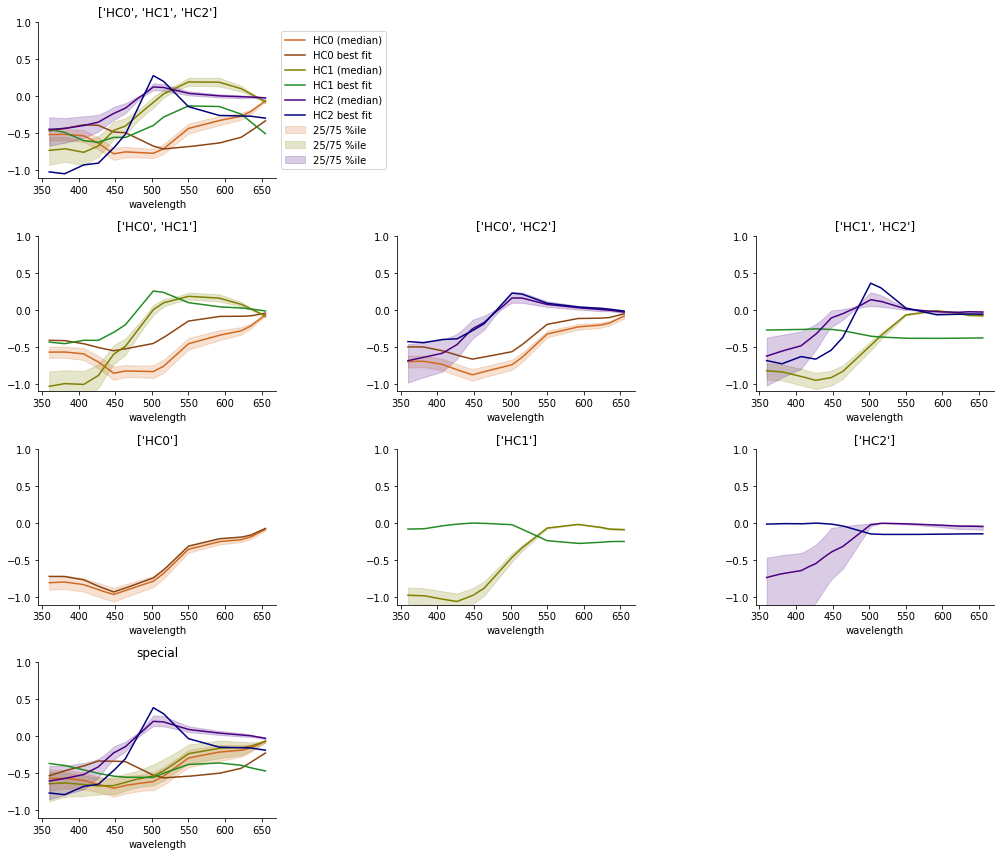

In [102]:
"""
plot HC 
"""
save=True

plot_best = True

special_mode=True


H_in_percentiles = np.copy(H_in_percentiles_25_75)

nrHC = [[0,1,2],[0,1],[0,2],[1,2],[0],[1],[2],[0,1,2]]

colors = ['chocolate', 'olive', 'indigo' ]
colors_best = ['saddlebrown', 'forestgreen', 'navy' ]


plt.figure(figsize=(14,12))
c=0
for j in range(8):
    
    if j==1:
        c=2
    
    plt.subplot(4,3,j+1+c)
    mode = modes[j]
    plt.title(mode)

    # plot only necessary HC
    for i in nrHC[j]:
        #plt.plot(wavelength,H_spectra_all[j][i],#/np.max(abs(H_spectra_all[j][i])),
        #         '-', 
        #         color=colors[i], 
        #         label='HC%.i'%i)          

        plt.plot(wavelength, 
                 H_in_percentiles[j,1,i], '-', 
                 color=colors[i], 
                 label='HC%.i (median)'%i)    
        plt.fill_between(wavelength, 
                         H_in_percentiles[j,0,i], 
                         H_in_percentiles[j,2,i],
                         color=colors[i], 
                         alpha=0.2, 
                         label='25/75 %ile')

        if plot_best:
            plt.plot(wavelength, 
                     H_spectra_all[j][i],
                     ls='-',
                     color=colors_best[i],
                    label='HC%.i best fit'%i)
                
    if j==0:
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
    plt.xlabel('wavelength')
    plt.ylim(-1.1,1)
    

plt.tight_layout()
sns.despine()

if save:
    filepath = '/gpfs01/berens/user/cschroeder/Documents/Biophysical Models/Cone_HC_interaction/Delfi/plots/plots_v5/'
    filename = 'HC_in'
    plt.savefig(filepath+filename+'.svg', dpi=300, format='svg',  bbox_inches='tight')
    plt.savefig(filepath+filename+'.eps', dpi=300, format='eps',  bbox_inches='tight')
    plt.savefig(filepath+filename+'.png', dpi=300, format='png',  bbox_inches='tight')

## saving results

In [97]:
k_best.shape

(8, 4, 296)

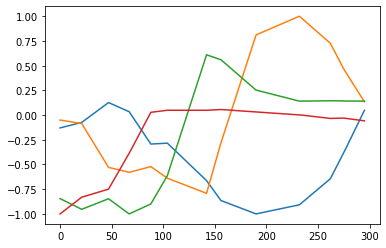

In [98]:
plt.plot(k_best[0].T)

In [101]:
"""
save relevant data
"""


# save as h5py

with h5py.File('Delfi/fit_results/v2/model_output.h5', 'w') as hf:
    hf.create_dataset("percentile_traces",  data=traces_percentiles_25_75)
    hf.create_dataset("best_traces",  data=k_best)
    hf.create_dataset("H_in_percentiles",  data=H_in_percentiles_25_75)
    hf.create_dataset("H_in_best",  data= H_spectra_all)



In [ ]:
"""
Meta data:
# model_modes, percentile (25,50,75), cone_type (r,g,b,uv) / HC_type, wavelength (360,...,655)
# modes: full, HC0&HC1, HC0&HC2, HC1&HC2, HC0, HC1, HC2
percentile_traces
H_in_percentiles


# model_modes, cone_type (r,g,b,uv) / HC_type, wavelength (360,...,655)
# modes: full, HC0&HC1, HC0&HC2, HC1&HC2, HC0, HC1, HC2
best_traces
H_in_best
"""
# load data:

with h5py.File('model_output.h5', 'r') as hf:
    percentile_traces = hf['percentile_traces'][:]
    best_traces = hf['best_traces'][:]
    H_in_percentiles = hf['H_in_percentiles'][:]
    H_in_best = hf['H_in_best'][:]
    
# all traces best
for i in range(4):
    plt.plot(best_traces[0][i])

# one trace: 25,50,75 percentiles
for i in range(3):
    plt.plot(percentile_traces[0,i,0])